# Assignment #2 Backpropogation 
## 1. Getting Started

In [2]:
import numpy as np
from matplotlib import pyplot

## 2. Read MNIST Data

In [3]:
import MNISTtools
# help(MNISTtools.load)
# help(MNISTtools.show)

In [4]:
xtrain, ltrain = MNISTtools.load(dataset = "training", path = "/datasets/MNIST")
print(xtrain.shape)
print(ltrain.shape)

(784, 60000)
(60000,)


### 2.1
What are the shapes of both variables? <br>
&nbsp;&nbsp;&nbsp;&nbsp;xtrain - (784, 60000), ltrain - (60000, 0)<br>
Whare is the size of the training dataset?<br>
&nbsp;&nbsp;&nbsp;&nbsp;60,000 images<br>
What is the feature dimension?<br>
&nbsp;&nbsp;&nbsp;&nbsp;784

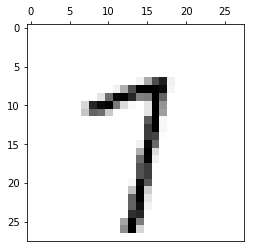

In [5]:
MNISTtools.show(xtrain[:, 42])

In [6]:
print(ltrain[42])
print('Min: ', np.amin(xtrain), 'Max: ', np.amax(xtrain))

7
('Min: ', 0, 'Max: ', 255)


### 2.3
What is the range of xtrain(min and max values)?<br> 
&nbsp;&nbsp;&nbsp;&nbsp;0 - 255<br>
What is the type of xtrain?<br>
&nbsp;&nbsp;&nbsp;&nbsp; xtrain is a numpy.ndarray
### 2.4 Normalize Images

In [7]:
def normalize_MNIST_images(x):
    # Normalize images from to [-1, 1]
    x = x.astype(np.float64) # convert to float
    xmax, xmin = x.max(), x.min()
    x = 2 * (x - xmin)/(xmax - xmin) - 1
    return x

#### Check normalize_MNIST_images()

In [8]:
xtrain = normalize_MNIST_images(xtrain)
print('Min: ', xtrain.min(), 'Max: ', xtrain.max()) 
print(xtrain.shape)

('Min: ', -1.0, 'Max: ', 1.0)
(784, 60000)


### 2.5  Convert labels to oneHot codes

In [9]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size)) 
    d[lbl, np.arange(0, lbl.size)] = 1 
    return d

#### Check label conversion

In [10]:
dtrain = label2onehot(ltrain)
print(dtrain.shape)
print(dtrain[:, 42])
print (ltrain[42])

(10, 60000)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


The one hot label of image 42, [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], is the correct binary vector representation of label 7.

### 2.6 Convert oneHot codes to labels

In [11]:
def onehot2label(d):
    lbl = d.argmax(axis=0) # need the max of each row
    return lbl

#### Check oneHot conversion

In [12]:
if np.array_equal(ltrain,onehot2label(dtrain)):
    print('One hot encoding and decoding successful')

One hot encoding and decoding successful


## 3. Activation functions
### 3.7 Numerically safe softmax

In [13]:
def softmax(a):
    # Compute softmax
    ga = np.exp(a - a.max(axis=0))
    return ga / ga.sum(axis=0)

#### Testing softmax

In [14]:
x2 = np.array([[1, 2, 1, 6],  # sample 1
               [2, 4, 2, 6],  # sample 2
               [1, 2, 1, 6]]) # sample 1 again(!)
print(softmax(x2))

[[0.21194156 0.10650698 0.21194156 0.33333333]
 [0.57611688 0.78698604 0.57611688 0.33333333]
 [0.21194156 0.10650698 0.21194156 0.33333333]]


### 3.8 Softmax derivative if i = j
\begin{align}
{g(a)_i} & = \frac{\exp({a_i})}{\sum_{j=1}^n\exp({a_j})} \\
Using\space quotient\space rule \space and\space simplifying... \\
\frac{\partial{g(a)_i}}{\partial{a_j}}& = \frac{\exp({a_i})\sum_{k=1}^n(\exp({a_k})-\exp({a_j}))}
{\sum_{k=1}^n\exp({a_k})} \\
& = \frac{\exp({a_j})}{\sum_{k=1}^n\exp({a_k})} x 
\frac{\sum_{k=1}^n(\exp({a_k}) - \exp({a_j}))}{\sum_{k=1}^n\exp({a_k})} \\
& = {p_i}(1 - {p_j})
\end{align}

### 3.9 Softmax derivative if i != j

\begin{align}
\frac{\partial{g(a)_i}}{\partial{a_j}}& = \frac{0 - \exp({a_i})\exp({a_j})}
{(\sum_{k=1}^n\exp({a_k}))^2} \\
& = \frac{- \exp({a_j})}{\sum_{k=1}^n\exp({a_k})} x \frac{\exp({a_i})}{\sum_{k=1}^n\exp({a_k})} \\
& = -{p_j}{p_i}
\end{align}
### 3.10 softmaxp

In [15]:
def softmaxp(a, e):
    ga = softmax(a)
    prod = ga * e
    dot = (ga * e).sum(axis=0)
    return prod - dot.T * ga

### 3.11 Checking spftmaxp()

In [16]:
eps = 1e-6 #finite difference step
a = np.random.randn(10, 200) #random inputs
e = np.random.randn(10, 200) # random directions
diff = softmaxp(a, e)
a_soft = softmax(a)
diff_approx = (softmax(a + e * eps) - a_soft) / eps
rel_error = np.abs(diff - diff_approx).mean() / np.abs(diff_approx).mean()
print(rel_error, ' should be smaller than 1e-6')

(5.067802993297125e-07, ' should be smaller than 1e-6')


### 3.12 ReLU

In [17]:
def relu(a):
    return a * (a > 0) # for speed
def relup(a, e):
    return (1 * (a > 0)) * e

## 4. Backpropagation
### 4.13 Network init

In [18]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.) 
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.)) 
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.)) 
    return W1, b1, W2, b2

In [19]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)

### 4.14  Forward prop

In [20]:
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    return y

In [21]:
yinit = forwardprop_shallow(xtrain, netinit)
print(yinit.shape)

(10, 60000)


### 4.15 eval loss

In [22]:
def eval_loss(y, d):
    result = -(d * np.log(y)).sum()/y.size
    return result

In [23]:
print(eval_loss(yinit, dtrain), 'should be around 0.26')

(0.323647544175474, 'should be around 0.26')


### 4.16 Eval perfs

In [24]:
def eval_perfs(y, lbl):
    y[y.argmax(axis=0), np.arange(0, y.shape[1])] = 1
    y[y < 1] = 0
    predicted_labels = onehot2label(y)
    return 1 - float(np.sum(predicted_labels == lbl))/float(y.shape[1]) 
print(eval_perfs(yinit, ltrain))

0.942716666667


Initially the shallow net shows very poor performance.
### 4.17 Update shallow

In [25]:
def update_shallow(x, d, net, gamma=0.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    
    # forward phase
    a1 = W1.dot(x) + b1 # [10x60k]
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2 # [64x60k]
    y = softmax(a2)
    
    # error
    e = eval_loss(y, d)

    # backward phase
    delta2 = softmaxp(a2, -d/y)
    delta1 = relup(a1, W2.T.dot(delta2))
    
    # gradient update
    W2 = W2 - gamma * delta2.dot(h1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis=1).reshape(No, 1)
    b1 = b1 - gamma * delta1.sum(axis=1).reshape(Nh, 1)
    return W1, b1, W2, b2

### 4.18 Backprop shallow

In [26]:
def backprop_shallow(x, d, net, T, gamma=.05): 
    lbl = onehot2label(d)
    for t in range(0, T):
        net = update_shallow(x, d, net, gamma)
        y = forwardprop_shallow(x, net)
        if t % 5 == 0:
            print('T: ', t, 'Loss: ', eval_loss(y, d), 'Error: ', eval_perfs(y, lbl))
    return net

In [27]:
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)

('T: ', 0, 'Loss: ', 0.29002366935074414, 'Error: ', 0.8750166666666667)
('T: ', 5, 'Loss: ', 0.1988206502104958, 'Error: ', 0.6394666666666666)
('T: ', 10, 'Loss: ', 0.16987073971559136, 'Error: ', 0.47865)
('T: ', 15, 'Loss: ', 0.14526569695436894, 'Error: ', 0.3618166666666667)
('T: ', 20, 'Loss: ', 0.12752412350960265, 'Error: ', 0.3406166666666667)
('T: ', 25, 'Loss: ', 0.11523718623131943, 'Error: ', 0.28595000000000004)
('T: ', 30, 'Loss: ', 0.1000031510533919, 'Error: ', 0.2675666666666666)
('T: ', 35, 'Loss: ', 0.08847981215407838, 'Error: ', 0.21120000000000005)
('T: ', 40, 'Loss: ', 0.08096666137039, 'Error: ', 0.20951666666666668)
('T: ', 45, 'Loss: ', 0.07509162123082153, 'Error: ', 0.18945)
('T: ', 50, 'Loss: ', 0.07060304214140696, 'Error: ', 0.18710000000000004)
('T: ', 55, 'Loss: ', 0.06682306639050681, 'Error: ', 0.17584999999999995)
('T: ', 60, 'Loss: ', 0.06353597363494799, 'Error: ', 0.1698833333333334)
('T: ', 65, 'Loss: ', 0.060793506345731066, 'Error: ', 0.16178

With 100 iterations The error reaches 13.1% and the loss is 0.049.
### 4.19 Testing


In [28]:
xtest, ltest = MNISTtools.load(dataset = "testing", path = "/datasets/MNIST")
print(xtest.shape, ltest.shape)
xtest = normalize_MNIST_images(xtest)
dtest = label2onehot(ltest)

((784, 10000), (10000,))


The testing dataset has 10,000 images. 

In [29]:
nettest = backprop_shallow(xtest, dtest, nettrain, 100)

('T: ', 0, 'Loss: ', 0.04705133175014649, 'Error: ', 0.1279)
('T: ', 5, 'Loss: ', 0.045860174851585556, 'Error: ', 0.12280000000000002)
('T: ', 10, 'Loss: ', 0.04481770360363279, 'Error: ', 0.12070000000000003)
('T: ', 15, 'Loss: ', 0.04388281268655895, 'Error: ', 0.11839999999999995)
('T: ', 20, 'Loss: ', 0.043034072061693386, 'Error: ', 0.1169)
('T: ', 25, 'Loss: ', 0.04225833694785958, 'Error: ', 0.11519999999999997)
('T: ', 30, 'Loss: ', 0.041544570720223585, 'Error: ', 0.11350000000000005)
('T: ', 35, 'Loss: ', 0.04088497909488696, 'Error: ', 0.11270000000000002)
('T: ', 40, 'Loss: ', 0.04027213422859759, 'Error: ', 0.11109999999999998)
('T: ', 45, 'Loss: ', 0.03970009936296261, 'Error: ', 0.10929999999999995)
('T: ', 50, 'Loss: ', 0.03916435602017621, 'Error: ', 0.10840000000000005)
('T: ', 55, 'Loss: ', 0.03866141318236335, 'Error: ', 0.10699999999999998)
('T: ', 60, 'Loss: ', 0.03818811426349461, 'Error: ', 0.10619999999999996)
('T: ', 65, 'Loss: ', 0.037741444165203454, 'Error

The trained network had much better performance and ran much faster. The error after 100 iterations was 9% and the loss was 0.034. 
### 4.20 Minibatch

In [30]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05): 
    N = x.shape[1]
    lbl = onehot2label(d)
    for t in range(0, T):
        for l in range(0, (N+B-1)/B):
            idx = np.arange(B*l, min(B*(l+1), N))
            net = update_shallow(x[:,idx], d[:,idx], net, gamma)
        y = forwardprop_shallow(x, net)
        print('T: ', t, 'Loss: ', eval_loss(y, d), 'Error: ', eval_perfs(y, lbl))    
    return net
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100)

0.05
('T: ', 0, 'Loss: ', 0.032253286103538975, 'Error: ', 0.09975)
('T: ', 1, 'Loss: ', 0.025454713795821916, 'Error: ', 0.0799333333333333)
('T: ', 2, 'Loss: ', 0.021422224959094894, 'Error: ', 0.06643333333333334)
('T: ', 3, 'Loss: ', 0.018568744170508043, 'Error: ', 0.057466666666666666)
('T: ', 4, 'Loss: ', 0.016275084244716475, 'Error: ', 0.050066666666666704)


### 4.21 Minibatch testing

In [31]:
netminibatchtest = backprop_minibatch_shallow(xtest, dtest, netminibatch, 5, B=100)

0.05
('T: ', 0, 'Loss: ', 0.014520325445517953, 'Error: ', 0.04479999999999995)
('T: ', 1, 'Loss: ', 0.013567646322539293, 'Error: ', 0.04190000000000005)
('T: ', 2, 'Loss: ', 0.012754572414239933, 'Error: ', 0.03979999999999995)
('T: ', 3, 'Loss: ', 0.012109770167981473, 'Error: ', 0.03700000000000003)
('T: ', 4, 'Loss: ', 0.01144972956659139, 'Error: ', 0.03590000000000004)


The minibatch algorithm is more efficient and has less error. For 5 epochs with minibatch size of 100, the error was 3.5% and the loss was 0.011. This is superior to the standard backprop algorithm.
### 5.22 More hidden nodes, minibatch algorithm

In [71]:
netinit16 = init_shallow(Ni, 16, No)
nettrain16  = backprop_minibatch_shallow(xtrain, dtrain, netinit16, 5, B=100)

('T: ', 0, 'Loss: ', 0.04002498231983609, 'Error: ', 0.12791666666666668)
('T: ', 1, 'Loss: ', 0.032066780781495684, 'Error: ', 0.1001333333333333)
('T: ', 2, 'Loss: ', 0.02929111365247636, 'Error: ', 0.09145000000000003)
('T: ', 3, 'Loss: ', 0.02692495868298967, 'Error: ', 0.0837)
('T: ', 4, 'Loss: ', 0.025539702025705695, 'Error: ', 0.07916666666666672)


In [73]:
nettest16  = backprop_minibatch_shallow(xtrain, dtrain, nettrain16, 5, B=100)

('T: ', 0, 'Loss: ', 0.024544890735134224, 'Error: ', 0.07563333333333333)
('T: ', 1, 'Loss: ', 0.02375407976651502, 'Error: ', 0.07316666666666671)
('T: ', 2, 'Loss: ', 0.023269078628798023, 'Error: ', 0.07153333333333334)
('T: ', 3, 'Loss: ', 0.022662641515778563, 'Error: ', 0.06963333333333332)
('T: ', 4, 'Loss: ', 0.02258204548738588, 'Error: ', 0.06993333333333329)


Increasing the number of hidden units to 16 did not improve the loss or error. At 100 iterations the error was 6.9% and the loss was 0.012.

In [74]:
netinit256 = init_shallow(Ni, 256, No)
nettrain256  = backprop_minibatch_shallow(xtrain, dtrain, netinit256, 5, B=100)

('T: ', 0, 'Loss: ', 0.030651057480846993, 'Error: ', 0.09550000000000003)
('T: ', 1, 'Loss: ', 0.023019820728543514, 'Error: ', 0.0713166666666667)
('T: ', 2, 'Loss: ', 0.018792362223676667, 'Error: ', 0.05783333333333329)
('T: ', 3, 'Loss: ', 0.015856981211198815, 'Error: ', 0.04795000000000005)
('T: ', 4, 'Loss: ', 0.013675140828283574, 'Error: ', 0.04079999999999995)


In [75]:
nettest256  = backprop_minibatch_shallow(xtrain, dtrain, nettrain256, 5, B=100)

('T: ', 0, 'Loss: ', 0.012012696133176763, 'Error: ', 0.03598333333333337)
('T: ', 1, 'Loss: ', 0.010663653351011835, 'Error: ', 0.03211666666666668)
('T: ', 2, 'Loss: ', 0.009620223740400639, 'Error: ', 0.028766666666666718)
('T: ', 3, 'Loss: ', 0.008748225762343504, 'Error: ', 0.026116666666666677)
('T: ', 4, 'Loss: ', 0.007944758098283487, 'Error: ', 0.02371666666666672)


Increasing the number of hidden units to 256 improved the loss and error over both the 16 hidden unit and 64 hiddden unit models. This leads me to believe that both of these models were underfitting the data. At 100 iterations the error was 2.3% and the loss was 0.007. 

### 5.23 Different step sizes
gamma = 0.02

In [31]:
nettrain_02 = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100, gamma=0.02)

0.02
('T: ', 0, 'Loss: ', 0.038928293379796884, 'Error: ', 0.11911666666666665)
('T: ', 1, 'Loss: ', 0.03198821916913864, 'Error: ', 0.09748333333333337)
('T: ', 2, 'Loss: ', 0.02831296096315423, 'Error: ', 0.08596666666666664)
('T: ', 3, 'Loss: ', 0.025660963952691657, 'Error: ', 0.07773333333333332)
('T: ', 4, 'Loss: ', 0.02366880987976596, 'Error: ', 0.07141666666666668)


In [32]:
nettest_02  = backprop_minibatch_shallow(xtrain, dtrain, nettrain_02, 5, B=100, gamma = 0.02)

0.02
('T: ', 0, 'Loss: ', 0.021843627724216816, 'Error: ', 0.06559999999999999)
('T: ', 1, 'Loss: ', 0.02031203396376363, 'Error: ', 0.06063333333333332)
('T: ', 2, 'Loss: ', 0.01901501886472041, 'Error: ', 0.056849999999999956)
('T: ', 3, 'Loss: ', 0.017920030612722657, 'Error: ', 0.05386666666666662)
('T: ', 4, 'Loss: ', 0.016880657492679536, 'Error: ', 0.0504)


Decreasing gamma to 0.02 from 0.05 leads to a larger error on the test dataset. This may be due to overfitting of the data (stuck in local minimum). <br>
gamma = 0.08

In [33]:
nettrain_08 = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100, gamma=0.08)

0.08
('T: ', 0, 'Loss: ', 0.031116383235996945, 'Error: ', 0.0994666666666667)
('T: ', 1, 'Loss: ', 0.022813333622077256, 'Error: ', 0.07179999999999997)
('T: ', 2, 'Loss: ', 0.018496814994522905, 'Error: ', 0.059116666666666706)
('T: ', 3, 'Loss: ', 0.01598138356733656, 'Error: ', 0.05066666666666664)
('T: ', 4, 'Loss: ', 0.014396118684122662, 'Error: ', 0.045950000000000046)


In [34]:
nettest_08  = backprop_minibatch_shallow(xtrain, dtrain, nettrain_08, 5, B=100, gamma = 0.08)

0.08
('T: ', 0, 'Loss: ', 0.013083715621820858, 'Error: ', 0.041616666666666635)
('T: ', 1, 'Loss: ', 0.012171453260641747, 'Error: ', 0.039416666666666655)
('T: ', 2, 'Loss: ', 0.011274903915371568, 'Error: ', 0.03634999999999999)
('T: ', 3, 'Loss: ', 0.010355135453320634, 'Error: ', 0.03354999999999997)
('T: ', 4, 'Loss: ', 0.009528260391666493, 'Error: ', 0.03069999999999995)


Increasing the step size, gamma, from 0.05 to 0.08 leads to a error of 0.03 and a loss of 0.009 with the test dataset. The training set has loss of 0.014 and error of 0.04. 

### 5.24 Different batch sizes
B = 50

In [35]:
nettrain50 = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=50)

0.05
('T: ', 0, 'Loss: ', 0.02633720190635944, 'Error: ', 0.08240000000000003)
('T: ', 1, 'Loss: ', 0.020634214637392203, 'Error: ', 0.0662166666666667)
('T: ', 2, 'Loss: ', 0.017636861751038357, 'Error: ', 0.05689999999999995)
('T: ', 3, 'Loss: ', 0.015528802495383546, 'Error: ', 0.05015000000000003)
('T: ', 4, 'Loss: ', 0.013797515601065595, 'Error: ', 0.044849999999999945)


In [36]:
nettest50 = backprop_minibatch_shallow(xtrain, dtrain, nettrain50, 5, B=50)

0.05
('T: ', 0, 'Loss: ', 0.013097869407156472, 'Error: ', 0.04235)
('T: ', 1, 'Loss: ', 0.011921564396522252, 'Error: ', 0.038516666666666644)
('T: ', 2, 'Loss: ', 0.011379999108697043, 'Error: ', 0.0369666666666667)
('T: ', 3, 'Loss: ', 0.01121387397381039, 'Error: ', 0.036800000000000055)
('T: ', 4, 'Loss: ', 0.01045096224582522, 'Error: ', 0.03420000000000001)


B = 200

In [37]:
nettrain200 = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=200)

0.05
('T: ', 0, 'Loss: ', 0.03696149491159031, 'Error: ', 0.11380000000000001)
('T: ', 1, 'Loss: ', 0.030014186415876637, 'Error: ', 0.09189999999999998)
('T: ', 2, 'Loss: ', 0.026220630489559162, 'Error: ', 0.07999999999999996)
('T: ', 3, 'Loss: ', 0.023440572460521936, 'Error: ', 0.07089999999999996)
('T: ', 4, 'Loss: ', 0.021185398515450767, 'Error: ', 0.06398333333333328)


In [38]:
nettest200 = backprop_minibatch_shallow(xtrain, dtrain, nettrain200, 5, B=200)

0.05
('T: ', 0, 'Loss: ', 0.019344751217925046, 'Error: ', 0.05845)
('T: ', 1, 'Loss: ', 0.017882536262317415, 'Error: ', 0.05413333333333337)
('T: ', 2, 'Loss: ', 0.01659804487985277, 'Error: ', 0.05010000000000003)
('T: ', 3, 'Loss: ', 0.015528618299999443, 'Error: ', 0.046666666666666634)
('T: ', 4, 'Loss: ', 0.014613277709524418, 'Error: ', 0.04353333333333331)


Increaseing the batch size to 200 caused a slight increase in the test dataset error. This is indicative of overfitting. For the test dataset the error is 0.04. For the training set the error is 0.06

### 5.25 Increasing the number of epochs

In [36]:
epochtrain = backprop_minibatch_shallow(xtrain, dtrain, netinit, 200, B=100)

0.05
('T: ', 0, 'Loss: ', 0.032253286103538975, 'Error: ', 0.09975)
('T: ', 1, 'Loss: ', 0.025454713795821916, 'Error: ', 0.0799333333333333)
('T: ', 2, 'Loss: ', 0.021422224959094894, 'Error: ', 0.06643333333333334)
('T: ', 3, 'Loss: ', 0.018568744170508043, 'Error: ', 0.057466666666666666)
('T: ', 4, 'Loss: ', 0.016275084244716475, 'Error: ', 0.050066666666666704)
('T: ', 5, 'Loss: ', 0.01467513678751892, 'Error: ', 0.044950000000000045)
('T: ', 6, 'Loss: ', 0.013186028447973104, 'Error: ', 0.040133333333333354)
('T: ', 7, 'Loss: ', 0.012067279779174624, 'Error: ', 0.03651666666666664)
('T: ', 8, 'Loss: ', 0.011184302836167812, 'Error: ', 0.03363333333333329)
('T: ', 9, 'Loss: ', 0.010382486224947645, 'Error: ', 0.031100000000000017)
('T: ', 10, 'Loss: ', 0.009727160428358759, 'Error: ', 0.029249999999999998)
('T: ', 11, 'Loss: ', 0.009148478434711121, 'Error: ', 0.027766666666666717)
('T: ', 12, 'Loss: ', 0.008720399140228135, 'Error: ', 0.02643333333333331)
('T: ', 13, 'Loss: ', 0.

('T: ', 107, 'Loss: ', 0.0009982454893644815, 'Error: ', 0.0026000000000000467)
('T: ', 108, 'Loss: ', 0.0009865465810475291, 'Error: ', 0.0025500000000000522)
('T: ', 109, 'Loss: ', 0.0009662633200858451, 'Error: ', 0.002466666666666617)
('T: ', 110, 'Loss: ', 0.0009503885708668903, 'Error: ', 0.002466666666666617)
('T: ', 111, 'Loss: ', 0.0009261526381955648, 'Error: ', 0.0023333333333332984)
('T: ', 112, 'Loss: ', 0.0008714640168470119, 'Error: ', 0.001983333333333337)
('T: ', 113, 'Loss: ', 0.000889642089170786, 'Error: ', 0.002083333333333326)
('T: ', 114, 'Loss: ', 0.0008618370122423979, 'Error: ', 0.0019166666666666776)
('T: ', 115, 'Loss: ', 0.0008458182429519014, 'Error: ', 0.0019000000000000128)
('T: ', 116, 'Loss: ', 0.0008061843998343175, 'Error: ', 0.0017500000000000293)
('T: ', 117, 'Loss: ', 0.000823388960352795, 'Error: ', 0.0018666666666666831)
('T: ', 118, 'Loss: ', 0.0008049586333840986, 'Error: ', 0.0017500000000000293)
('T: ', 119, 'Loss: ', 0.0007741417208654562, 

In [ ]:
epochtest = backprop_minibatch_shallow(xtrain, dtrain, epochtrain, 200, B=100)

0.05
('T: ', 0, 'Loss: ', 0.00026162431160159887, 'Error: ', 8.333333333332416e-05)
('T: ', 1, 'Loss: ', 0.000262739583310177, 'Error: ', 8.333333333332416e-05)
('T: ', 2, 'Loss: ', 0.0002567947510857342, 'Error: ', 8.333333333332416e-05)
('T: ', 3, 'Loss: ', 0.0002549720117022428, 'Error: ', 8.333333333332416e-05)
('T: ', 4, 'Loss: ', 0.00025374907235304304, 'Error: ', 8.333333333332416e-05)
('T: ', 5, 'Loss: ', 0.0002492168197916451, 'Error: ', 8.333333333332416e-05)
('T: ', 6, 'Loss: ', 0.0002485775386143003, 'Error: ', 8.333333333332416e-05)
('T: ', 7, 'Loss: ', 0.00024627712882617904, 'Error: ', 8.333333333332416e-05)
('T: ', 8, 'Loss: ', 0.00024124641464205653, 'Error: ', 4.999999999999449e-05)
('T: ', 9, 'Loss: ', 0.00024037421254307788, 'Error: ', 6.666666666665932e-05)
('T: ', 10, 'Loss: ', 0.00023832300177662868, 'Error: ', 8.333333333332416e-05)
('T: ', 11, 'Loss: ', 0.00023538067000013123, 'Error: ', 8.333333333332416e-05)
('T: ', 12, 'Loss: ', 0.00023372105973152037, 'Erro

('T: ', 110, 'Loss: ', 0.00010821982994713549, 'Error: ', 0.0)
('T: ', 111, 'Loss: ', 0.00010763635104129271, 'Error: ', 0.0)
('T: ', 112, 'Loss: ', 0.00010685553756335739, 'Error: ', 0.0)
('T: ', 113, 'Loss: ', 0.00010646829221895961, 'Error: ', 0.0)
('T: ', 114, 'Loss: ', 0.00010527363340205519, 'Error: ', 0.0)
('T: ', 115, 'Loss: ', 0.0001046069525864973, 'Error: ', 0.0)
('T: ', 116, 'Loss: ', 0.00010448935249847584, 'Error: ', 0.0)
('T: ', 117, 'Loss: ', 0.00010326615981103943, 'Error: ', 0.0)
('T: ', 118, 'Loss: ', 0.00010304771339384928, 'Error: ', 0.0)
('T: ', 119, 'Loss: ', 0.00010181554920515751, 'Error: ', 0.0)
('T: ', 120, 'Loss: ', 0.00010186505306922492, 'Error: ', 0.0)
('T: ', 121, 'Loss: ', 0.00010151651725879781, 'Error: ', 0.0)
('T: ', 122, 'Loss: ', 0.00010035021406999632, 'Error: ', 0.0)
('T: ', 123, 'Loss: ', 9.96516019038253e-05, 'Error: ', 0.0)
('T: ', 124, 'Loss: ', 9.924603185755066e-05, 'Error: ', 0.0)
('T: ', 125, 'Loss: ', 9.846860936777295e-05, 'Error: ', 0.

With T = 10 the test dataset error is 0.02.<br>
With T = 100 the training dataset error @ 100 is 0.0037 (minimum of 0.00365). The test dataset error is 8.3e-5.<br>
With T = 200, the training set error is 8.3e-05 and the test set error converges to 0 after 82 iterations. This seems unlikely and overfitting may be occuring.